In [2]:
import numpy as np
from scipy import stats
from scipy.stats import rv_continuous

class pvalue_distribution(rv_continuous):
    def __init__(self, d, n, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.d = d  # Effect size
        self.n = n  # Degrees of freedom
        self.delta = d * np.sqrt(n)  # Non-centrality parameter

    def _pdf(self, p):
        """
        Probability density function of the p-value distribution.
        """
        # Critical t-value under the null hypothesis for a two-sided test
        t_c = stats.t.ppf(1 - p / 2, self.n)

        # PDFs of the non-central t-distribution at t_c and -t_c
        nct_pdf_pos = stats.nct.pdf(t_c, self.n, self.delta)
        nct_pdf_neg = stats.nct.pdf(-t_c, self.n, self.delta)

        # PDF of the central t-distribution at t_c
        t_pdf = stats.t.pdf(t_c, self.n)

        # Compute the derivative dt_c/dp
        dt_c_dp = -1 / (2 * t_pdf)

        # Compute the PDF of the p-value distribution
        pdf = (nct_pdf_pos - nct_pdf_neg) * np.abs(dt_c_dp)
        return pdf

    def _cdf(self, p):
        """
        Cumulative distribution function of the p-value distribution.
        """
        # Critical t-value under the null hypothesis for a two-sided test
        t_c = stats.t.ppf(1 - p / 2, self.n)

        # CDFs of the non-central t-distribution
        nct_cdf_pos = stats.nct.sf(t_c, self.n, self.delta)  # Survival function for T >= t_c
        nct_cdf_neg = stats.nct.cdf(-t_c, self.n, self.delta)  # CDF for T <= -t_c

        # Compute the CDF of the p-value distribution
        cdf = nct_cdf_pos + nct_cdf_neg
        return cdf

    def _rvs(self, size=None, random_state=None):
        """
        Random variates of the p-value distribution.
        """
        # Generate random t-values from the non-central t-distribution
        t_values = stats.nct.rvs(df=self.n, nc=self.delta, size=size, random_state=random_state)

        # Compute the corresponding p-values
        p_values = 2 * stats.t.sf(np.abs(t_values), df=self.n)
        return p_values

In [103]:
pvalue_distribution(d=0.0, n=100).pdf(0.05)

np.float64(0.0)

In [105]:
# as a test, integrate the pdf from 0 to 1
from scipy.integrate import quad
quad(pvalue_distribution(d=0.01, n=100).pdf, 0, 1)


(0.07965567455361756, 3.423864525231579e-10)

In [100]:
pvalue_distribution(d=0.5, n=100).pdf(0.05)



np.float64(0.040817203588919826)

In [12]:
dist = pvalue_distribution(d=0.5, n=100)
import matplotlib.pyplot as plt

# sample 10000 p-values and draw a histogram
p_values = dist.rvs(size=10000)
# plt.hist(p_values, bins=50, density=True, alpha=0.75)
# plt.show()

In [22]:
from scipy.stats import kstest

# Generate a large sample of p-values
p_values = dist.rvs(size=1000000)

# Perform the KS test
D, p_value = kstest(p_values, dist.cdf)

print(f"KS Statistic: {D}, p-value: {p_value}")

KS Statistic: 0.0005243641415109135, p-value: 0.946057384199996


In [23]:
cut_off_pvals = p_values[p_values < 0.05]

In [74]:
# def estimate_effect_size(p_values):
def test_for_right_skew(p_values, verbose=False):
    pps = p_values / 0.05

    # Ensure pps values are within (0, 1)
    pps = pps[(pps > 0) & (pps < 1)]  # Exclude pps == 0 and pps == 1 to avoid infinities

    if len(pps) == 0:
        if verbose:
            print("No p-values in the range to test.")
        return None

    # Clip pps to avoid issues with extreme values
    pps = np.clip(pps, 1e-10, 1 - 1e-10)

    # Compute z-scores for each pps using Stouffer's method
    z_scores = stats.norm.isf(pps)

    # Compute combined Z-score
    combined_z = np.sum(z_scores) / np.sqrt(len(z_scores))

    # Compute the p-value associated with the combined Z-score
    p_value = stats.norm.sf(combined_z)

    if verbose:
        print(f"Stouffer's method combined Z-score: {combined_z}, p-value: {p_value}")

    return p_value
    
vals = pvalue_distribution(d=0.1, n=100).rvs(size=10000)
vals = vals[vals < 0.05]
test_for_right_skew(vals)


np.float64(9.185376507503729e-60)

In [72]:
# now, let's devise a different test, something that partitions the p-values into three buckets: [0, 0.001), [0.001, 0.01), [0.01, 0.05] , and checks if the proportions of p-values in each bucket are as expected under the null hypothesis.

def test_for_right_skew_2(p_values, verbose=False):
    import numpy as np
    from scipy.stats import chisquare

    # Define bins
    bins = [0, 0.001, 0.01, 0.05]

    # Filter p-values to be within [0, 0.05]
    p_values = p_values[(p_values >= 0) & (p_values <= 0.05)]
    n = len(p_values)
    if n == 0:
        if verbose:
            print("No p-values in the range to test.")
        return None

    # Compute observed counts in each bin
    observed_counts, _ = np.histogram(p_values, bins=bins)

    # Compute expected counts under the null hypothesis (uniform distribution)
    bin_widths = np.diff(bins)
    total_width = 0.05  # Total width of the range
    expected_proportions = bin_widths / total_width
    expected_counts = n * expected_proportions

    # Perform chi-squared goodness-of-fit test
    chi2_statistic, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)

    if verbose:
        print(f"Chi-squared statistic: {chi2_statistic}, p-value: {p_value}")

    return p_value

vals = pvalue_distribution(d=0.0, n=100).rvs(size=10000)
vals = vals[vals < 0.05]
test_for_right_skew_2(vals)


np.float64(0.21750721235294931)

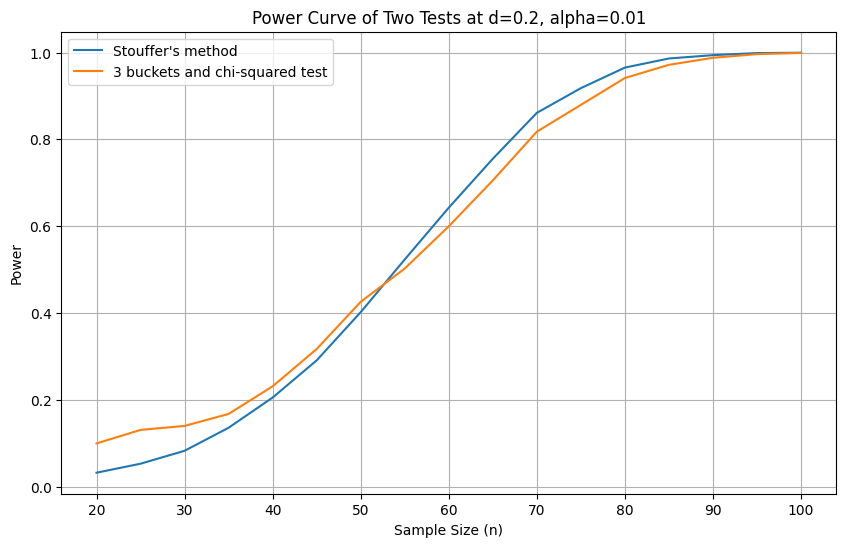

In [98]:
# now let's confirm the power of these two tests

import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from typing import Callable, List, Optional

def single_simulation(
    test_func: Callable[[np.ndarray], Optional[float]],
    d: float,
    n: int,
    alpha: float
) -> int:
    # Generate p-values under effect size d
    pvals = pvalue_distribution(d=d, n=n).rvs(size=n)
    pvals = pvals[pvals < 0.05]
    # Apply the test
    p_value = test_func(pvals)
    if p_value is not None and p_value < alpha:
        return 1
    else:
        return 0

def estimate_power(
    test_func: Callable[[np.ndarray], Optional[float]],
    n_values: np.ndarray,
    n_simulations: int = 1000,
    d: float = 0.1,
    alpha: float = 0.05
) -> List[float]:
    powers: List[float] = []
    for n in n_values:
        n_int = int(n)  # Ensure n is an integer
        args_list = ((test_func, d, n_int, alpha) for _ in range(n_simulations))
        with multiprocessing.Pool(16) as pool:
            results = pool.starmap(single_simulation, args_list)
        rejections = sum(results)
        power = rejections / n_simulations
        powers.append(power)
    return powers

d_fixed = 0.2  # Fixed effect size
n_values = np.arange(20, 101, 5)  # Vary n from 20 to 200 in steps of 10
n_simulations = 100000
alpha = 0.01

# Estimate power for test_for_right_skew
power_test1 = estimate_power(test_for_right_skew, n_values, n_simulations, d_fixed, alpha)

# Estimate power for test_for_right_skew_2
power_test2 = estimate_power(test_for_right_skew_2, n_values, n_simulations, d_fixed, alpha)

# Plot the power curves
plt.figure(figsize=(10, 6))
plt.plot(n_values, power_test1, label="Stouffer's method")
plt.plot(n_values, power_test2, label='3 buckets and chi-squared test')
plt.xlabel('Sample Size (n)')
plt.ylabel('Power')
plt.title(f'Power Curve of Two Tests at d={d_fixed}, alpha={alpha}')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# from scipy.optimize import minimize_scalar

# # Define the negative log-likelihood function
# def neg_log_likelihood(d, pvals, n):
#     dist = pvalue_distribution(d=d, n=n)
#     pdf_values = dist.pdf(pvals)
#     # Avoid log(0) by setting very small pdf values to a minimum positive value
#     pdf_values = np.maximum(pdf_values, 1e-300)
#     return -np.sum(np.log(pdf_values))

# # Estimate the effect size by minimizing the negative log-likelihood
# result = minimize_scalar(neg_log_likelihood, args=(cut_off_pvals, 100), bounds=(0, 2), method='bounded')

# # Extract the estimated effect size
# estimated_d = result.x

# print(f"Estimated effect size (d): {estimated_d}")


/tmp/ipykernel_18108/3241248290.py:27: RuntimeWarning: divide by zero encountered in divide
  dt_c_dp = -1 / (2 * t_pdf)


Estimated effect size (d): 0.7639320225002102


In [95]:
np.random.seed(42)
test_d1 = np.random.normal(0.2, 0.05, size=10000)
test_d2 = np.random.normal(0.0, 0.05, size=10000)

# welch's t-test
stats.ttest_ind(test_d1, test_d2, equal_var=False)



TtestResult(statistic=np.float64(281.10582130481555), pvalue=np.float64(0.0), df=np.float64(19997.88029039437))